## Breast Cancer Wisconsin dataset

In [5]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [6]:
df.shape

(569, 32)

### Create class response and relabel

In [7]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [8]:
le.transform(['M', 'B'])

array([1, 0])

### Split into training and test

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, 
                     test_size=0.20,
                     stratify=y,
                     random_state=1)

## Grid search

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import numpy

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_range = numpy.logspace(0.001, 1.0, 10)
param_range2 = numpy.logspace(0.001, 1.0, 10)

param_grid = [{'svc__C': param_range, 
               'svc__gamma': param_range2, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9758241758241758
{'svc__C': 1.0002302850208247, 'svc__kernel': 'linear'}


#### Optimal parameters

In [12]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))
# ... or:
gs.decision_function(X_train) # (silly)
print('Test accuracy: %.3f' % gs.score(X_test, y_test))

Test accuracy: 0.965
Test accuracy: 0.965


#### Range of parameters

In [ ]:
gs.cv_results_['mean_test_score']

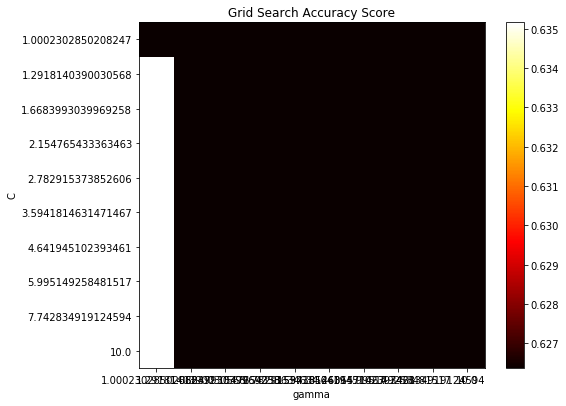

In [13]:
import matplotlib.pyplot as plt
import numpy as np
scores = gs.cv_results_['mean_test_score'].reshape(len(param_range),len(param_range2))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(param_range2)), param_range2)
plt.yticks(np.arange(len(param_range)), param_range)
plt.title('Grid Search Accuracy Score')
plt.show()

### Try: Copy, paste and:
- Finetune in promising area (only RBF)
- Plot results

In [ ]:
#
#
#
#
#
#

Back to presentation

## Nested cross-validation

In [ ]:
from sklearn.model_selection import cross_val_score
import time

inner_segments = 5
outer_segments = 5
n_models = inner_segments*outer_segments*len(param_grid)
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=inner_segments)

t1 = time.time()
scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=outer_segments)
t2 = time.time()

print('Total time: %.3fs, time per model: %.3fs' % (t2-t1, (t2-t1)/n_models))
print('Number of models (segments x parameters): %d' % (n_models))
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

#### Decision trees, same data

In [ ]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), 
                                      np.std(scores)))

### Manual outer loop
Assess stability of parameters

In [ ]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5,
                        random_state=1).split(X_train, y_train)

for k, (train, test) in enumerate(kfold):
    # GridSearchCV with inner splitting
    gs.fit(X_train[train,:],y_train[train])
    
    # Inner results
    param   = gs.cv_results_['param_max_depth'][np.argmax(gs.cv_results_['mean_test_score'])]
    in_acc  = round(np.max(gs.cv_results_['mean_test_score']),4)
    
    # Outer accuracy
    out_acc = round(gs.score(X_train[test,:], y_train[test]),4)
    
    # Print
    print('Chosen max_depth: ' + str(param) \
         + ', with accuracies: ' + str(in_acc) + ', ' + str(out_acc))